## Applying SSP model on the Cells Dataset

In [1]:
import numpy as np
import os
import time
import torch
import matplotlib.pyplot as plt
import random

from torch.utils.data import DataLoader
from copy import deepcopy
from PIL import Image, ImageOps
from util.utils import set_seed, visualize
from torch.nn import DataParallel
from torch.optim import SGD
from tqdm import tqdm
from torchvision import transforms
from model.SSP_matching import SSP_MatchingNet
from dataset.cells_dataset import CellsDataset

### Transform Functions

In [2]:
def normalize(img, mask):
    """
    :param img: PIL image
    :param mask: PIL image, corresponding mask
    :return: normalized torch tensor of image and mask
    """
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])(img)
    mask = torch.from_numpy(np.array(mask)).long()
    return img, mask

In [3]:
def hflip(img, mask):
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
    return img, mask

In [4]:
def crop(img, mask, size):
    # padding height or width if smaller than cropping size
    w, h = img.size
    padw = size - w if w < size else 0
    padh = size - h if h < size else 0
    img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
    mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=255)

    # cropping
    w, h = img.size
    x = random.randint(0, w - size)
    y = random.randint(0, h - size)
    img = img.crop((x, y, x + size, y + size))
    mask = mask.crop((x, y, x + size, y + size))

    return img, mask

Função de congelamento dos pesos

In [5]:
def freeze_weights(model):
    for param in model.layer0.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False

    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            for param in module.parameters():
                param.requires_grad = False

In [6]:
def train_model(model, trainloader, criterion, optimizer, args, save_path):
    # gpu casting
    model = DataParallel(model).to(args['device'])
    best_model = None
    iters = 0
    total_iters = args['episode'] // args['batch_size']
    lr_decay_iters = [total_iters // 3, total_iters * 2 // 3]
    previous_best = 0

    # each snapshot is considered as an epoch
    epoch_total = args['episode'] // args['snapshot']
    for epoch in range(epoch_total):
        print("\n==> Epoch %i of %i, learning rate = %.5f\t\t\t\t Previous best = %.2f"
              % (epoch + 1,epoch_total, optimizer.param_groups[0]["lr"], previous_best))

        model.train()

        for module in model.modules():
            if isinstance(module, torch.nn.BatchNorm2d):
                module.eval()

        total_loss = 0.0
        tbar = tqdm(trainloader)
        set_seed(int(time.time()))

        for i, (img_s_list, mask_s_list, img_q, mask_q) in enumerate(tbar):
            img_q, mask_q = img_q.to(args['device']), mask_q.to(args['device'])
            for k in range(len(img_s_list)):
                img_s_list[k], mask_s_list[k] = img_s_list[k].to(args['device']), mask_s_list[k].to(args['device'])

            out_ls = model(img_s_list, mask_s_list, img_q, mask_q)
            mask_s = torch.cat(mask_s_list, dim=0)

            # computing self support loss
            if args['refine']:
                loss = criterion(out_ls[0], mask_q) + criterion(out_ls[1], mask_q) + criterion(out_ls[2], mask_q) + criterion(out_ls[3], mask_s) * 0.2
            else:
                loss = criterion(out_ls[0], mask_q) + criterion(out_ls[1], mask_q) + criterion(out_ls[2], mask_s) * 0.2

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            iters += 1

            if iters in lr_decay_iters:
                optimizer.param_groups[0]['lr'] /= 10.0
            tbar.set_description('Loss: %.3f' % (total_loss / (i + 1)))

            # Tensorboard log
            with train_summary_writer.as_default():
              summary.scalar('total loss', total_loss, step = epoch)

        miou = evaluate_model(model, testloader, args)
        if miou >= previous_best:
                best_model = deepcopy(model)
                previous_best = miou

    # o total mIOU será alterado quando a avaliação do modelo estiver implementada
    total_miou = 0.0
    # saving the model
    torch.save(best_model.module.state_dict(),
               os.path.join(save_path, '%s_%ishot_%.2f.pth' % (args['backbone'], args['shot'], total_miou)))

### Execução da rede

Defining the hyperparameters and configurations.

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
args = {
    'data_root': 'data/CellsDatasetOriginal',            #  - root path of training dataset
    'dataset':'cells',                    #  - training dataset
    'batch_size': 1,                      #  - batch size of training
    'lr': 0.001,                          #  - learning rate
    'crop_size':473,                      #  - cropping size of training samples
    'backbone': 'resnet50',               #  - backbone of semantic segmentation model
    'refine': False,
    'fold': 0,                            #  - validation fold
    'shot': 1,                            #  - number of support pairs
    'episode': 100,                       #  - total episodes of training
    'snapshot': 5,                        #  - save the model after each snapshot episodes
    'seed': 1,                            #  - random seed to generate tesing samples
    'device': device
}
args['device']

device(type='cpu')

Obtaining the dataset

In [8]:
def get_loaders(data_root, batch_size):
    '''Returns the train and test dataset'''
    train_set = CellsDataset(data_root, mode = 'train')
    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)

    test_set = CellsDataset(data_root, mode = 'val')
    testloader = DataLoader(
        test_set, batch_size=1, shuffle=False, pin_memory=True, num_workers=2, drop_last=False)
    return train_loader, testloader


In [9]:
trainloader, testloader = get_loaders(args['data_root'], args['batch_size'])

['1', '2', '3', '4', '5', '6']
['7', '8', '9', '10']


Opening the trained model

In [10]:
CHECKPOINT_PATH = './checkpoints/best.pth'

In [11]:
model = SSP_MatchingNet(args['backbone'], args['refine'])
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))
model

SSP_MatchingNet(
  (layer0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


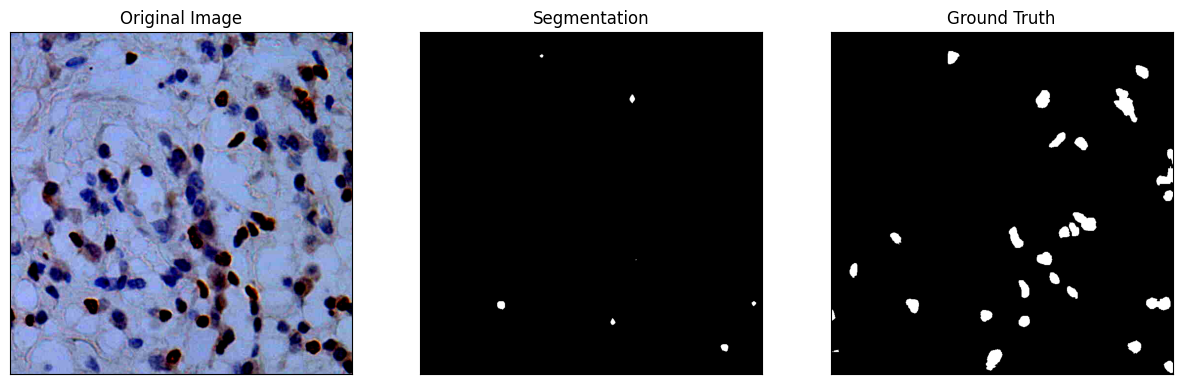

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


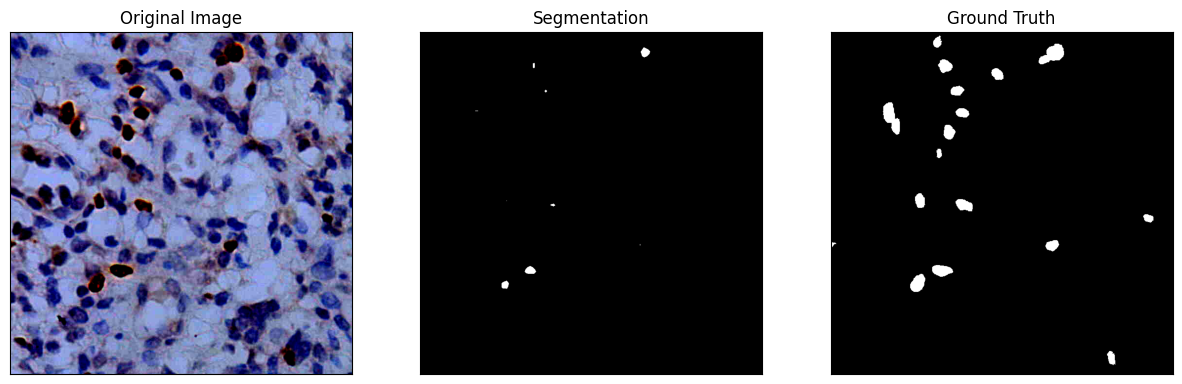

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


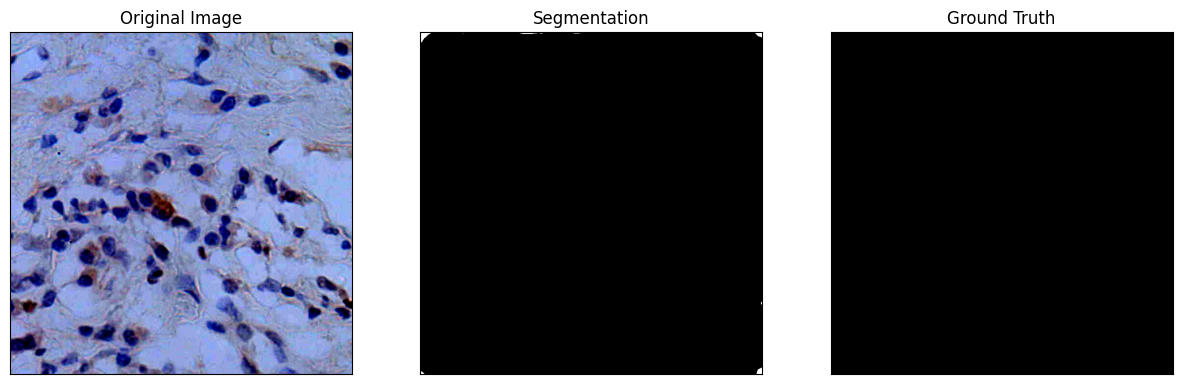

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


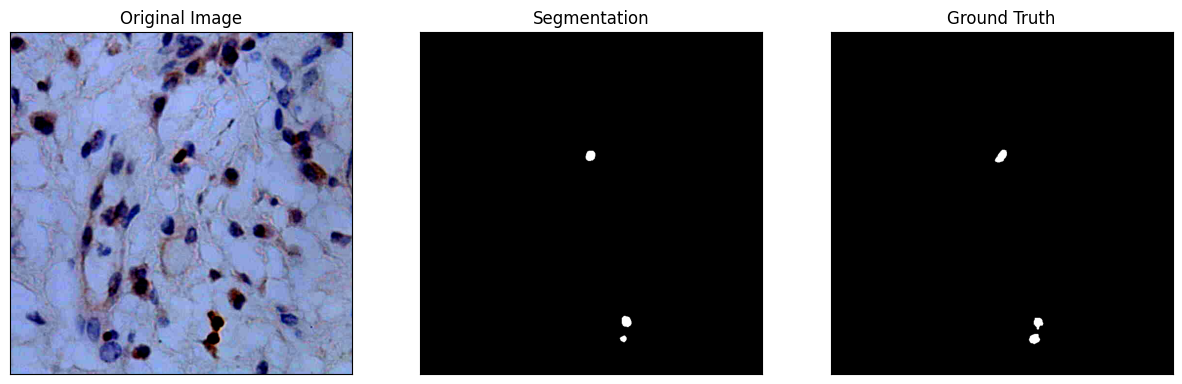

In [12]:
model.eval()
i = 0
for img_s_list, mask_s_list, img_q, mask_q in testloader:
    img_q, mask_q = img_q.to(args['device']), mask_q.to(args['device'])
    for k in range(len(img_s_list)):
        img_s_list[k], mask_s_list[k] = img_s_list[k].to(args['device']), mask_s_list[k].to(args['device'])
    out_ls = model(img_s_list, mask_s_list, img_q, mask_q)
    img = img_q.squeeze(0)
    pred = torch.argmax(out_ls[0], dim=1)
    plot_img = img.detach().cpu().numpy().transpose(1,2,0)
    plot_mask = mask_q.detach().cpu().numpy().transpose(1,2,0)
    plot_pred = pred.detach().cpu().numpy().transpose(1,2,0)

    plot_mask = (plot_mask.squeeze(2))
    plot_pred = (plot_pred.squeeze(2))
    visualize(Original_Image=plot_img, Segmentation=plot_pred, Ground_Truth=plot_mask)
    i += 1